# <center> Missing data </center>
### By the end of this lecture, you will be able to
- Describe and compare the three main types of missingness patterns
- Evaluate simple approaches for handling missing values
- Apply multivariate imputation to a dataset



## Missing values often occur in datasets
- survey data: not everyone answers all the questions
- medical data: not all tests/treatments/etc are performed on all patients
- sensor can be offline or malfunctioning

## Missing values are an issue for multiple reasons

#### Concenptual reason
- missing values can introduce biases
    - bias: the samples (the data points) are not representative of the underlying distribution/population
    - any conclusion drawn from a biased dataset is also biased.
    - rich people tend to not fill out survey questions about their salaries and the mean salary estimated from survey data tend to be lower than true value


#### Practical reason
- missing values (NaN, NA, inf) are incompatible with sklearn
   - all values in an array need to be numerical otherwise sklearn will throw a *ValueError*
- there are a few supervised ML techniques that work with missing values (e.g., XGBoost)
   - we will cover those later this semester during a follow-up lecture on missing data

### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Describe and compare the three main types of missingness patterns**
- <font color='LIGHTGRAY'>Evaluate simple approaches for handling missing values</font>
- <font color='LIGHTGRAY'>Apply multivariate imputation to a dataset</font>


# Missing data patterns

- MCAR - Missing Complete At Random
- MAR - Missing At Random
- MNAR - Missing Not At Random

## MCAR - Missing Complete At Random

- the reason the values are missing are related to an unobserved variable
- in other words, the missingness pattern does not correlate with any of the observed variables
- the data sample is still representative of the underlying distribution/population
- your best case scenario but usually rare

## MCAR examples
- some people randomly fail to fill in some values in a survey 
- sensor randomly malfunctions
- apps, websites are unavailable sometimes

## MAR - Missing At Random

- Name is misleading! Better name would be 'Missing Conditionally at Random' but the MCAR acronym is taken. 
- the reason why values are missing in one feature is correlated another feature

## MAR examples
- missing value in blood pressure data conditional on age
   - older people are more likely to have their blood pressure measured during a regular check-up than younger people
- males are less likely to fill in a depression survey
   - this has nothing to do with their level of depression after accounting for maleness

## MNAR - Missing Not At Random

- the reason the feature contains missing values is related to the value of the feature itself
- most severe case of missingness!
- not many ML approaches can deal with this pattern correctly

## MNAR examples
- depressed people are less likely to fill out a survey on depression because of their level of depression
- rich people don't fill out survey info on  their salaries because they are rich and don't want to reveal how much they earn
- temperature sensor doesn't work because the observed temperature is outside of range

## MAR can be identifed by a statistical test

- [Little, 1988](https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722)
- pdf of article in week4 folder
- the approach:
    - given a feature with missing values, it creates a mask which is 0 if feature is not missing and 1 if feature is missing
    - loop through the other features in the dataset
        - collect the other feature values if mask = 0 and if mask = 1, these are our two samples
        - use a statistical test to check if the two samples are different
    - if the answer is yes, MAR is at least partially responsible for the missing values
    - if answer is no, we might have MCAR or MNAR
       - the test can't distinguish MCAR from MNAR

## What to do when you get a dataset with missing values?
- it can be challenging to infer the missingness pattern from an incomplete dataset
   - you might work with a subject matter expert who can tell you or guess why some values are missing with some confidece
   - but as far as I know, it is impossible to infer the missingness patterns just from a dataset
- do some simple diagnostics!
   - which features contain missing values?
   - what fraction of the values are missing in each feature?
   - are the features categorical or continuous?
   - what fraction of points contain at least one missing feature value?

## Example
- kaggle house price dataset
- check out the train.csv and the dataset description in the `data` folder!

In [1]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df
print(X.shape)
# the feature names
ftrs = df.columns

(1460, 79)


In [2]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (1460, 79)
fraction of missing values in features:
LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64
data types of the features with missing values:
LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC    

## Lecture 7, Quiz 2 on canvas
True or false?

### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe and compare the three main types of missingness patterns</font>
- **Evaluate simple approaches for handling missing values**
- <font color='LIGHTGRAY'>Apply multivariate imputation to a dataset</font>


## Simple approaches for handling missing values

- exclude points or features with missing values
- categorical feature: treat missing values as another category
- continuous feature: sklearn's SimpleImputer


### Exclude points or features with missing values
- easy to do with pandas
- it can be an ACCEPTABLE approach:
    - only small fraction of points contain missing values (maybe just a few percent?)
    - all missing values occur in one or a few features and you have good reason to believe those features will not be important anyway
    - it is OK to ignore a point with missing values when the model is deployed  
       - not always the case! think of medical or finance problems!
- due to the smaller sample size, the confidence of your model might suffer but usually not a lot

##### Drop points or features with missing values
- not OK for the house price dataset because all points contain some NaNs.

In [3]:
print(df.shape)
# by default, rows/points are dropped
df_r = df.dropna()
print(df_r.shape)
# drop features with missing values
df_c = df.dropna(axis=1)
print(df_c.shape)


(1460, 79)
(0, 79)
(1460, 60)


### Categorical feature: treat missing values as another category

- the BEST thing you can do!
- already covered in the preprocessing lecture (one hot encoding)
- example: missing values in gender
    - if survey only has options for male/female, missing values are likely because those people are outside the gender binary
    - it is a bad idea to impute (try to guess male or female and thus boxing them into the binary)
- example: native country in the adult data
    - missing data are represented as ` ?`
    - a one-hot encoded feature was assigned to the missing category


In [4]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
ftrs = df.columns

(1460, 79)


In [5]:
random_state = 42

# let's split to train, CV, and test
X_train, X_other, y_train, y_other = train_test_split(df, y, train_size=0.6, random_state=random_state)
X_CV, X_test, y_CV, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=random_state)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(876, 79)
(292, 79)
(292, 79)


In [6]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [7]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

random_state = 42

# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
# We need to replace the NaN with a string first!
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [8]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.transformers_[0][-1] + \
                list(preprocessor.named_transformers_['cat'][1].get_feature_names(cat_ftrs)) + \
                preprocessor.transformers_[2][-1]

# you can convert the numpy array back to a data frame with the feature names if you want
df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)
print(feature_names)

(876, 223)
(292, 223)
(292, 223)
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'Alley_missing', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr

In [9]:
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df_train[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (876, 223)
fraction of missing values in features:
LotFrontage    0.190639
MasVnrArea     0.002283
GarageYrBlt    0.052511
dtype: float64
data types of the features with missing values:
LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object
fraction of points with missing values: 0.23972602739726026


## Lecture 7, Quiz 3 on canvas
The gender feature below contains missing values. Please explain how you would encode it and would be the output of the encoder. Do not write code. The goal of this quiz is to test your conceptual understanding so write text and the output array.

gender = ['Male', 'Female', 'Male', NaN, NaN, 'Female']


### Continuous feature: sklearn's SimpleImputer

- Imputation means you infer the missing values from the known part of the data
- sklearn's SimpleImputer can do mean and median imputation
- USUALLY A BAD IDEA!
   - mean or median imputation decreases the variance of the feature

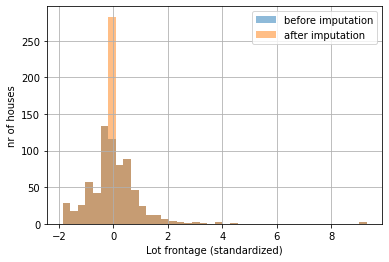

std before imputation: 1.0
std after imputation: 0.8996447802291788


In [10]:
import matplotlib.pyplot as plt

si = SimpleImputer(strategy='mean')
X_lot = si.fit_transform(df_train[['LotFrontage']])

df_train['LotFrontage'].hist(bins=40,label = 'before imputation',alpha=0.5)
plt.hist(X_lot,bins=40,label='after imputation',alpha=0.5)
plt.xlabel('Lot frontage (standardized)')
plt.ylabel('nr of houses')
plt.legend()
plt.show()

print('std before imputation:',np.std(df_train['LotFrontage']))
print('std after imputation:',np.std(X_lot))

### <font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe and compare the three main types of missingness patterns</font>
- <font color='LIGHTGRAY'>Evaluate simple approaches for handling missing values</font>
- **Apply multivariate imputation to a dataset**


## Multivariate imputation

- models each feature with missing values as a function of other features, and uses that estimate for imputation
   - at each step, a feature column is designated as target variable y and the other feature columns are treated as inputs X
   - a regressor is trained on (X, y) for known y
   - then, the regressor is used to predict the missing values of y
- paper [here](https://www.jstatsoft.org/article/view/v045i03) and pdf in folder
- fails for MNAR

## Does it make sense to impute values?
- what continuous features have missing values?
- why are the values missing?
   - health care: maybe a test was not performed on all patients, that's why some test results are missing
      - would you feel comfortable guessing what the test results would have been if it had been performed?
   - in the house price dataset, GarageYrBlt is one of the continuous features with missing values
      - it is missing if the house has no garage!
      - therefore an imputed GarageYrBlt value is meaningless 
- not always a good approach but it might work under some circumstances

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
help(IterativeImputer)

Help on class IterativeImputer in module sklearn.impute._iterative:

class IterativeImputer(sklearn.impute._base._BaseImputer)
 |  IterativeImputer(estimator=None, *, missing_values=nan, sample_posterior=False, max_iter=10, tol=0.001, n_nearest_features=None, initial_strategy='mean', imputation_order='ascending', skip_complete=False, min_value=-inf, max_value=inf, verbose=0, random_state=None, add_indicator=False)
 |  
 |  Multivariate imputer that estimates each feature from all the others.
 |  
 |  A strategy for imputing missing values by modeling each feature with
 |  missing values as a function of other features in a round-robin fashion.
 |  
 |  Read more in the :ref:`User Guide <iterative_imputer>`.
 |  
 |  .. versionadded:: 0.21
 |  
 |  .. note::
 |  
 |    This estimator is still **experimental** for now: the predictions
 |    and the API might change without any deprecation cycle. To use it,
 |    you need to explicitly import ``enable_iterative_imputer``::
 |  
 |      >>

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

print(df_train[['LotFrontage','MasVnrArea','GarageYrBlt']].head())

imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=10, random_state=1000))
X_impute = imputer.fit_transform(df_train)
df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)

print(df_train_imp[['LotFrontage','MasVnrArea','GarageYrBlt']].head())

# save training data into a csv, we will use this csv in the next notebook
df_train_imp.assign(SalePrice=y_train.values).to_csv('data/house_price_prep_imputed.csv',index=False)

df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

   LotFrontage  MasVnrArea  GarageYrBlt
0    -0.372911   -0.606613    -2.126354
1    -0.678966   -0.606613    -1.927257
2          NaN    0.706580     0.063711
3     0.200943   -0.606613     0.422085
4    -0.066855   -0.606613     1.138834
   LotFrontage  MasVnrArea  GarageYrBlt
0    -0.372911   -0.606613    -2.126354
1    -0.678966   -0.606613    -1.927257
2     0.522302    0.706580     0.063711
3     0.200943   -0.606613     0.422085
4    -0.066855   -0.606613     1.138834


/Users/azsom/opt/anaconda3/envs/data1030/lib/python3.9/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


## Multivariate imputation: uncertainty estimate

- create multiple imputed datasets with different random states (at least 3 but 5 or more is recommended)
- run each imputed dataset through your ML pipeline
- measure the uncertainty of the predicted target variable (mean and stdev of each points' predicted labels)
- this procedure will let you estimate the uncertainty due to the randomness in imputation

## Another lecture on missing data later!
- there are advanced methods to deal with missing values in contunous features (without imputation)
- but we need to cover a couple of other things first before we can discuss those techniques

## Lecture 7, Quiz 4 on Canvas
Consider how multivariate imputation works. Please explain in a couple of sentences why it fails for MNAR! Feel free to check out the paper of the method (pdf in the repository) or check out the sklearn pages below for more info!

https://scikit-learn.org/stable/modules/impute.html#iterative-imputer

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html